In [1]:
import gzip


In [256]:

import pandas as pd
import numpy as np

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
from textblob import TextBlob, Word
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords, wordnet, words

from sklearn.feature_extraction import text
import pickle
import scipy.sparse
import re
import string
from itertools import cycle

from langdetect import detect


from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD, NMF,LatentDirichletAllocation
from sklearn.cluster import KMeans

from wordcloud import WordCloud
import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\12157\AppData\Roaming\nltk_data...


In [3]:
with gzip.open('./METIS/reviewsNY.csv.gz') as f:

    reviews_NY = pd.read_csv(f)

reviews_NY.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [4]:
reviews_NY.shape

(848725, 6)

In [ ]:
reviews_NY.listing_id.nunique()

In [ ]:
reviews_NY.reviewer_id.nunique()

In [ ]:
reviews_NY.date.min()

In [ ]:
reviews_NY.date.max()

In [ ]:
reviews_NY.isnull().sum()

In [5]:
reviews_NY.dropna(subset=['comments'], inplace =True)

In [ ]:
def detect_lang(text):
    return detect(text)


#reviews_NY["language"] = reviews_NY['comments'].apply(detect_lang)
#reviews_NY["language"] =reviews_NY['comments'].map(lambda x: detect_lang(x))

In [ ]:
#from textblob import TextBlob
#reviews_NY['language'] = reviews_NY['comments'].apply(lambda x: TextBlob(x).detect_language())

In [6]:
def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

#reviews_NY = reviews_NY[reviews_NY['comments'].apply(detect_en)]


In [50]:
# Sample subset of review data set 
reviews_sml = reviews_NY.sample(n=50000, random_state = 42)



In [51]:
reviews_sml = reviews_sml[reviews_sml['comments'].apply(detect_en)]

In [52]:
reviews_sml.shape

(44519, 6)

In [54]:
# create a column for whether a review is an automated posting (yes, no)
def autopost(x):
    if 'an automated posting' in x:
        return False
    else:
        return True
reviews_sml  = reviews_sml[reviews_sml['comments'].apply(autopost)]

In [53]:
# Remove numbers, capital letters, punctuation, extra blank spaces, etc.

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_non_english_chars = lambda x: re.sub('[^a-zA-Z0-9_]', ' ', x)
extra_space = lambda x: re.sub('!{2,}', ' ', x)

reviews_sml["comments_cln"] = reviews_sml["comments"].map(alphanumeric).map(punc_lower).map(remove_non_english_chars).map(extra_space)

In [86]:
# Pre-processing & Lemmatizing text #

def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

reviews_sml['comments_lmn'] = reviews_sml['comments_cln'].apply(lambda x: lemmatize_with_postag(x))#lemmatization

In [88]:
reviews_sml.drop('comments_leman', axis =1, inplace = True)

In [89]:
reviews_sml.shape

(43947, 8)

In [90]:
#Store data in pickle object to use for modeling
reviews_sml.to_pickle('reviews_Eng.pickle')

In [91]:
df= pd.read_pickle('reviews_Eng.pickle')
df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_cln,comments_lmn
690518,31267560,735699981,2021-03-01,387277763,Jasmine,Lakshmee was amazing ! Very nice for one night...,lakshmee was amazing very nice for one night...,lakshmee be amaze very nice for one night she ...
620226,25626152,282142661,2018-06-26,91671544,Marvin,Hyas place was awesome! She was very helpful ...,hyas place was awesome she was very helpful ...,hyas place be awesome she be very helpful and ...
560286,21786958,272487388,2018-06-03,92399364,Kristina,Sharon is super nice. the whole stay was great...,sharon is super nice the whole stay was great...,sharon be super nice the whole stay be great w...


In [242]:
stopwords_addition = ["airbnb", "bnb", "a", "aa", "aaa", "br", "york", "need", "make",
                      "good", "great", "perfect", "br", "amazing", "recommend", "place", "like", "nice",
                    "room", "stay", "overall", "really", "check",  "unit", "did", "didn", "day",
                    "night", "just", "super", "love",  "days", "lot","awesome", "ny",
                    "definitely", "wonderful", "reservation",  "s", "locate","nyc", "location",'thanks','thank', "brooklyn", 
                      "manhattan", "away", "station", "time", "come","thoroughly","ve",'t']
custom_stopwords = text.ENGLISH_STOP_WORDS.union(stopwords_addition)

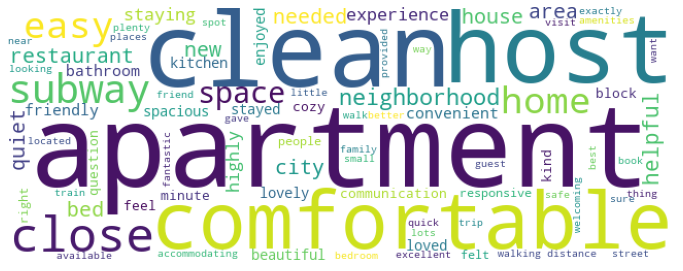

In [229]:
from wordcloud import WordCloud

words = " ".join(str(w) for w in df.comments_cln)
plt.subplots(figsize=(12,6))
wordcloud = WordCloud(stopwords =custom_stopwords, background_color='white',width=650,height=250,max_words=80).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('name.png',bbox_inches = 'tight')
plt.show()


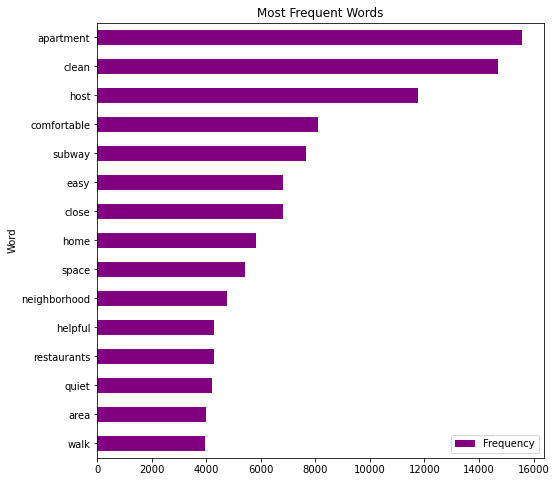

In [320]:
top_N = 15

words = nltk.tokenize.word_tokenize(" ".join(str(w) for w in df.comments_cln))
    #df.comments_cln.str.cat(sep = ' '))

words1 = [word for word in words if word not in custom_stopwords]
    
word_dist = nltk.FreqDist(words1)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
rslt.sort_values(by='Frequency').plot.barh(x='Word',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")
plt.savefig('frequent_hist.png',bbox_inches = 'tight')
plt.show()

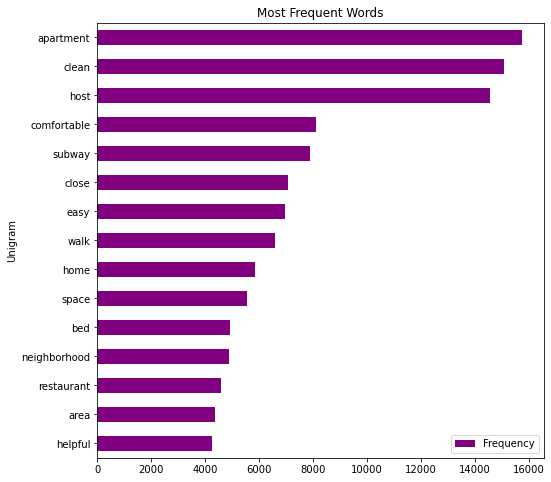

In [321]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['comments_lmn'], 15)
df2 = pd.DataFrame(common_words, columns = ['Unigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df2.sort_values(by='Frequency').plot.barh(x='Unigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")
plt.savefig('unigram_hist.png',bbox_inches = 'tight')
plt.show()

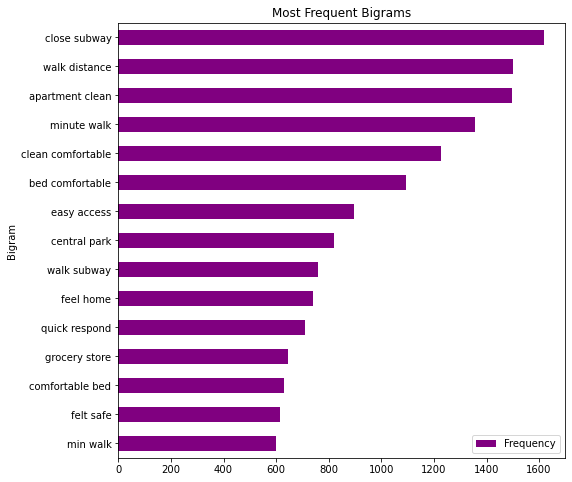

In [322]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['comments_lmn'], 15)
df3 = pd.DataFrame(common_words, columns = ['Bigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df3.sort_values(by='Frequency').plot.barh(x='Bigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Bigrams")
plt.savefig('bigram_hist.png',bbox_inches = 'tight')
plt.show()

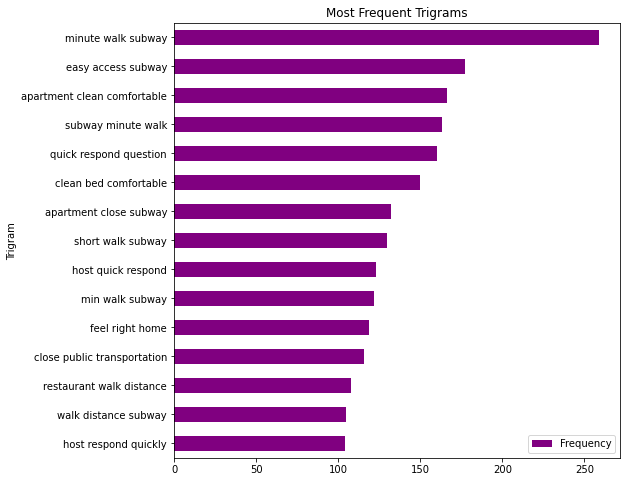

In [323]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=custom_stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['comments_lmn'], 15)
df4 = pd.DataFrame(common_words, columns = ['Trigram' , 'Frequency'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df4.sort_values(by='Frequency').plot.barh(x='Trigram',
                      y='Frequency',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Trigrams")
plt.savefig('trigram_hist.png',bbox_inches = 'tight')
plt.show()

In [154]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=10):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [143]:
docs = df["comments_lmn"]

In [319]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_cln,comments_lmn
690518,31267560,735699981,2021-03-01,387277763,Jasmine,Lakshmee was amazing ! Very nice for one night...,lakshmee was amazing very nice for one night...,lakshmee be amaze very nice for one night she ...
620226,25626152,282142661,2018-06-26,91671544,Marvin,Hyas place was awesome! She was very helpful ...,hyas place was awesome she was very helpful ...,hyas place be awesome she be very helpful and ...
560286,21786958,272487388,2018-06-03,92399364,Kristina,Sharon is super nice. the whole stay was great...,sharon is super nice the whole stay was great...,sharon be super nice the whole stay be great w...
795187,42233237,667104874,2020-09-22,450855,Maria Jose,"Nice apt, nice bathroom, nice mattress, but ve...",nice apt nice bathroom nice mattress but ve...,nice apt nice bathroom nice mattress but very ...
846818,50773840,404233394171661050,2021-07-11,410357003,Sandhya,This was our first Airbnb rental. The place is...,this was our first airbnb rental the place is...,this be our first airbnb rental the place be e...


# TFIDF / NMF

TF-IDF Vectorizer
NMF topic modeler

In [191]:
#Baseline model
preprocessor = None
vectorizer = TfidfVectorizer(stop_words=custom_stopwords)  
topic_modeler = NMF(15, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 WALK, AREA, MINUTE, NEW, CITY, HOUSE, EXPERIENCE, RESTAURANT, DISTANCE, BATHROOM 

Topic 1:
 HOST, RESPONSIVE, EXCELLENT, KIND, ACCOMMODATE, FANTASTIC, BEST, COMMUNICATION, GRACIOUS, RESPOND 

Topic 2:
 CLEAN, SPACIOUS, STYLISH, HOUSE, BATHROOM, COMFY, COMMUNICATION, PRIVATE, SPARKLE, MODERN 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC, RESPONSIVE, EXACTLY, BUILDING, EQUIP, CUTE 

Topic 4:
 CLOSE, SUBWAY, RESTAURANT, SHOP, TRAIN, PUBLIC, PARK, METRO, TRANSPORTATION, BAR 

Topic 5:
 COMFORTABLE, BED, SPACIOUS, FELT, EXTREMELY, SHOWER, SLEEP, SURE, LARGE, FEEL 

Topic 6:
 EASY, COMMUNICATION, ACCESS, COMMUNICATE, QUICK, VALUE, EXCELLENT, PROCESS, CITY, SUBWAY 

Topic 7:
 SPACE, BEAUTIFUL, VALUE, STYLISH, EXCELLENT, PLENTY, RESPONSIVE, AMENITY, CUTE, COOL 

Topic 8:
 HIGHLY, RECOMMENDED, EXCELLENT, FANTASTIC, COMMUNICATION, LOVELY, HOSPITALITY, SPACIOUS, ACCOMMODATE, EXPERIENCE 

Topic 9:
 HOME, BEAUTIFUL, FEEL, LOVELY, FELT, WELCOME, HOUSE, FAMILY, ABSOLUTELY, 

In [187]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler1);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, EASY, WALK, SPACE, HOME, NEIGHBORHOOD, HIGHLY, RESTAURANT, CLOSE SUBWAY 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HELPFUL HOST 

Topic 2:
 CLEAN, CLEAN HOST, CLEAN COMFORTABLE, CLEAN QUIET, APARTMENT CLEAN, HOST CLEAN, CLEAN SPACIOUS, QUIET, SPACIOUS, CLEAN COZY 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT CLOSE, APARTMENT SPACIOUS, SPACIOUS APARTMENT, LOVELY 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, BED, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN, COMFORTABLE APARTMENT, COMFORTABLE SPACE, SPACIOUS COMFORTABLE, COMFORTABLE HOST 



In [188]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler1); #this one looks promising 

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 COMFORTABLE, SPACE, HOME, BEAUTIFUL, BED, HIGHLY, LOVELY, FEEL, FELT, AMAZE 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT, ACCOMMODATE, KIND, HIGHLY, COMMUNICATION, FANTASTIC 

Topic 2:
 CLEAN, QUIET, SPACIOUS, COZY, CONVENIENT, COMFORTABLE, COMMUNICATION, EASY, STYLISH, FRIENDLY 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC, NEW, ENJOY, RESPONSIVE, HELPFUL, EXACTLY 

Topic 4:
 CLOSE, SUBWAY, EASY, WALK, RESTAURANT, MINUTE, NEIGHBORHOOD, PARK, TRAIN, CITY 



C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [193]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8) 
topic_modeler1 = NMF(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler1, 5);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 COMFORTABLE, SPACE, HOME, BEAUTIFUL, BED 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT 

Topic 2:
 CLEAN, QUIET, SPACIOUS, COZY, CONVENIENT 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, EXCELLENT, FANTASTIC 

Topic 4:
 CLOSE, SUBWAY, EASY, WALK, RESTAURANT 



C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [189]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler2 = NMF(10, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler2);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 HOME, WALK, NEIGHBORHOOD, ENJOY, QUIET, AREA, HELPFUL, MINUTE, HOUSE, FRIENDLY 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HOST RESPONSIVE 

Topic 2:
 CLEAN, CLEAN HOST, CLEAN COMFORTABLE, APARTMENT CLEAN, CLEAN QUIET, HOST CLEAN, CLEAN SPACIOUS, QUIET, SPACIOUS, CLEAN COZY 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, BEAUTIFUL, APARTMENT SPACIOUS, APARTMENT CLOSE, SPACIOUS APARTMENT 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, BED, COMFORTABLE CLEAN, COMFORTABLE BED, BED COMFORTABLE, COMFORTABLE APARTMENT, SPACIOUS COMFORTABLE, COMFORTABLE SPACE, APARTMENT COMFORTABLE 

Topic 5:
 HIGHLY, HOST HIGHLY, HIGHLY RECOMMENDED, RECOMMENDED, AMAZE, CLEAN HIGHLY, EXCELLENT, APARTMENT HIGHLY, COMFORTABLE HIGHLY, FANTASTIC 

Topic 6:
 CLOSE, CLOSE SUBWAY, SUBWAY, CLEAN CLOSE, RESTAURANT, APARTMENT CLOSE, CLOSE TRAIN, CLOSE METRO, SHOP, TRAIN 

Topic 7:
 EXPERI

In [192]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler3 = NMF(4, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler3);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, COMFORTABLE, EASY, SPACE, WALK, HOME, HIGHLY, NEIGHBORHOOD, RESTAURANT 

Topic 1:
 HOST, FRIENDLY, FRIENDLY HOST, CLEAN HOST, RESPONSIVE, HELPFUL, EXCELLENT HOST, HOST CLEAN, EXCELLENT, HOST RESPONSIVE 

Topic 2:
 CLEAN, CLEAN COMFORTABLE, COMFORTABLE, CLEAN HOST, APARTMENT CLEAN, CLEAN QUIET, HOST CLEAN, COMFORTABLE CLEAN, CLEAN SPACIOUS, SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT CLOSE, APARTMENT SPACIOUS, SPACIOUS APARTMENT, LOVELY 



In [215]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler3 = NMF(4, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler3);

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 CLOSE, SUBWAY, EASY, WALK, SPACE, HOME, COMFORTABLE, NEIGHBORHOOD, RESTAURANT, AREA 

Topic 1:
 HOST, FRIENDLY, HELPFUL, RESPONSIVE, EXCELLENT, HIGHLY, ACCOMMODATE, KIND, AMAZE, COMMUNICATION 

Topic 2:
 CLEAN, COMFORTABLE, QUIET, SPACIOUS, COZY, CONVENIENT, COMMUNICATION, STYLISH, SPACE, HIGHLY 

Topic 3:
 APARTMENT, SPACIOUS, LOVELY, BEAUTIFUL, EXCELLENT, FANTASTIC, HIGHLY, RESPONSIVE, NEW, ENJOY 



# Coherence Score

c_v ranges from 0 to 1 with 1 being perfectly coherent topics.

In [285]:
def process_text(text):
    text = [w for w in text if w not in custom_stopwords]
    return text
docs_clean=  df["comments_lmn"].apply(process_text)

5


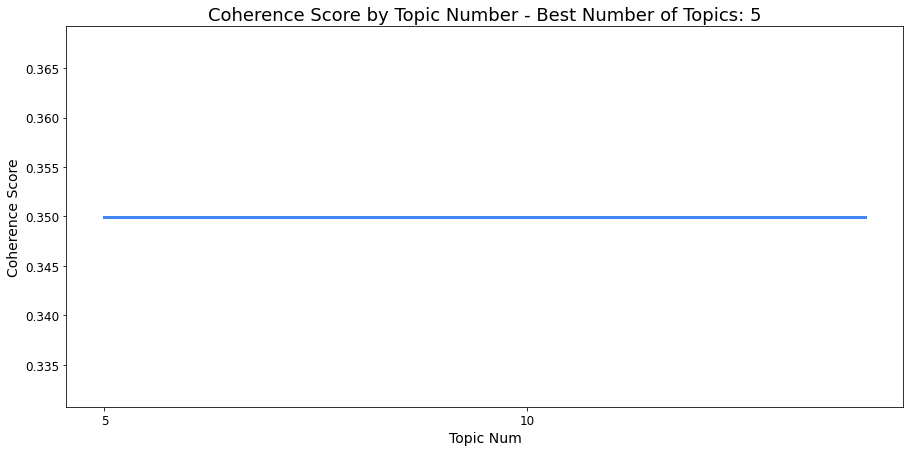

In [297]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

#Create a dictionary
dictionary = Dictionary(docs_clean)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in docs_clean]



# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5,15, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        random_state=10
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=docs_clean,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)


# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.savefig('coherenceNMF.png')
plt.show()


In [312]:

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stopwords,
    max_df=0.8,
    ngram_range=(1, 2),
   )


tfidf = tfidf_vectorizer.fit_transform(docs)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=10,
    max_iter=500,
    solver='cd',
    random_state=10
).fit(tfidf)


# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(docs))

n_top_words = 8
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topics)

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words = 8  
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
#topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
#topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,0,1,2,3,4,5,6,7,topics
0,home,walk,neighborhood,enjoy,quiet,area,helpful,minute,home walk neighborhood enjoy quiet area helpfu...
1,host,friendly,friendly host,clean host,responsive,helpful,excellent host,host clean,host friendly friendly host clean host respons...
2,clean,clean host,clean comfortable,apartment clean,clean quiet,host clean,clean spacious,quiet,clean clean host clean comfortable apartment c...
3,apartment,apartment clean,clean apartment,host apartment,spacious,beautiful apartment,beautiful,apartment spacious,apartment apartment clean clean apartment host...
4,comfortable,clean comfortable,bed,comfortable clean,comfortable bed,bed comfortable,comfortable apartment,spacious comfortable,comfortable clean comfortable bed comfortable ...


In [313]:
topic_df['topics'].to_csv('LDAtopic.csv')

# TFIDF / SVD

In [198]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.7) 
topic_modeler4 = TruncatedSVD(5, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler4);

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, FRIENDLY, HIGHLY 

Topic 1:
 HOST, FRIENDLY HOST, HOST HIGHLY, EXCELLENT HOST, HELPFUL HOST, AMAZE HOST, RESPONSIVE HOST, HOST RESPONSIVE, HOST HELPFUL, CLEAN HOST 

Topic 2:
 CLEAN, HOST, CLEAN COMFORTABLE, CLEAN HOST, HOST CLEAN, CLEAN QUIET, COMFORTABLE CLEAN, CLEAN CONVENIENT, CLEAN COZY, CLEAN SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, APARTMENT SPACIOUS, SPACIOUS APARTMENT, EXCELLENT 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, APARTMENT, HIGHLY, SPACE, BED, HOME, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN 



In [200]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords, max_df = 0.8)  
topic_modeler4 = TruncatedSVD(5, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler4);#this is promising 

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, WALK, NEIGHBORHOOD 

Topic 1:
 HOST, FRIENDLY, RESPONSIVE, HELPFUL, EXCELLENT, ACCOMMODATE, KIND, AMAZE, GRACIOUS, HIGHLY 

Topic 2:
 CLEAN, COMFORTABLE, COZY, SPACIOUS, STYLISH, QUIET, COMMUNICATION, SPARKLE, SPACE, PRIVATE 

Topic 3:
 APARTMENT, CLEAN, SPACIOUS, RESPONSIVE, HOST, EXCELLENT, FANTASTIC, EQUIP, EXACTLY, BUILDING 

Topic 4:
 CLOSE, SUBWAY, CLEAN, RESTAURANT, EASY, WALK, CONVENIENT, HOST, TRAIN, MINUTE 



In [197]:
preprocessor = None
vectorizer1 = TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,2), max_df = 0.8) 
topic_modeler5 = TruncatedSVD(6, random_state=10)

make_topics(docs, preprocessor, vectorizer1, topic_modeler5);

Topic 0:
 HOST, CLEAN, APARTMENT, COMFORTABLE, CLOSE, SUBWAY, EASY, SPACE, FRIENDLY, HIGHLY 

Topic 1:
 HOST, FRIENDLY HOST, HOST HIGHLY, EXCELLENT HOST, HELPFUL HOST, AMAZE HOST, RESPONSIVE HOST, HOST RESPONSIVE, HOST HELPFUL, CLEAN HOST 

Topic 2:
 CLEAN, HOST, CLEAN COMFORTABLE, CLEAN HOST, HOST CLEAN, CLEAN QUIET, COMFORTABLE CLEAN, CLEAN CONVENIENT, CLEAN COZY, CLEAN SPACIOUS 

Topic 3:
 APARTMENT, APARTMENT CLEAN, CLEAN, CLEAN APARTMENT, HOST APARTMENT, SPACIOUS, BEAUTIFUL APARTMENT, SPACIOUS APARTMENT, APARTMENT SPACIOUS, APARTMENT CLOSE 

Topic 4:
 COMFORTABLE, CLEAN COMFORTABLE, HIGHLY, APARTMENT, BED, SPACE, HOME, BED COMFORTABLE, COMFORTABLE BED, COMFORTABLE CLEAN 

Topic 5:
 HIGHLY, BEAUTIFUL, AMAZE, HOME, EXPERIENCE, SPACE, EASY, COMMUNICATION, HOST HIGHLY, QUICK 



# TFIDF / LatentDirichletAllocation

In [209]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler6 = LatentDirichletAllocation(n_components=20, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler6);

Topic 0:
 SPACE, CLEAN, HOST, APARTMENT, COMFORTABLE, WALK, CLOSE, EASY, SUBWAY, NEIGHBORHOOD 

Topic 1:
 APARTMENT, CLEAN, HOST, SUBWAY, EASY, WALK, CLOSE, COMFORTABLE, SPACE, NEIGHBORHOOD 

Topic 2:
 COMFORTABLE, CLEAN, HOST, APARTMENT, EASY, SUBWAY, CLOSE, NEIGHBORHOOD, SPACE, HOME 

Topic 3:
 APARTMENT, CLEAN, HOST, SUBWAY, CLOSE, EASY, COMFORTABLE, NEIGHBORHOOD, WALK, SPACE 

Topic 4:
 HOST, APARTMENT, CLEAN, CLOSE, SUBWAY, SPACE, WALK, COMFORTABLE, BED, EASY 

Topic 5:
 WALK, SUBWAY, CLEAN, EASY, HOST, CLOSE, COMFORTABLE, APARTMENT, NEIGHBORHOOD, HOME 

Topic 6:
 SPACE, EASY, WALK, COMFORTABLE, SUBWAY, APARTMENT, NEIGHBORHOOD, HOST, BED, CLEAN 

Topic 7:
 EASY, CLEAN, HOST, APARTMENT, SUBWAY, WALK, COMFORTABLE, CLOSE, SPACE, NEIGHBORHOOD 

Topic 8:
 HOST, APARTMENT, CLEAN, CLOSE, SUBWAY, WALK, BED, NEIGHBORHOOD, EASY, COMFORTABLE 

Topic 9:
 CLEAN, HOST, APARTMENT, SUBWAY, WALK, CLOSE, BED, EASY, NEIGHBORHOOD, COMFORTABLE 

Topic 10:
 NEIGHBORHOOD, HOST, CLEAN, APARTMENT, WALK, C

In [303]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  # Single change to add in common English stop words.
topic_modeler7 = LatentDirichletAllocation(n_components=10, random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler7,10);

Topic 0:
 SPACE, CLEAN, COMFORTABLE, HOST, WALK, APARTMENT, BED, HOME, EASY, SUBWAY 

Topic 1:
 APARTMENT, CLEAN, HOST, WALK, SUBWAY, COMFORTABLE, EASY, CLOSE, BED, HOME 

Topic 2:
 COMFORTABLE, BED, CLEAN, APARTMENT, HOST, WALK, SUBWAY, EASY, HOME, CLOSE 

Topic 3:
 RESTAURANT, APARTMENT, SUBWAY, WALK, CLOSE, HOST, CLEAN, COMFORTABLE, HOME, EASY 

Topic 4:
 HOST, CLEAN, APARTMENT, WALK, COMFORTABLE, HOME, EASY, SUBWAY, BED, NEIGHBORHOOD 

Topic 5:
 SUBWAY, CLOSE, WALK, CLEAN, HOST, APARTMENT, COMFORTABLE, EASY, BED, HOME 

Topic 6:
 NEIGHBORHOOD, WALK, APARTMENT, HOST, SUBWAY, CLEAN, COMFORTABLE, HOME, CLOSE, EASY 

Topic 7:
 EASY, WALK, CLEAN, HOST, SUBWAY, APARTMENT, COMFORTABLE, HOME, RESTAURANT, CLOSE 

Topic 8:
 CLOSE, HOST, CLEAN, SUBWAY, APARTMENT, HOME, WALK, COMFORTABLE, EASY, BED 

Topic 9:
 CLEAN, HOME, HOST, COMFORTABLE, WALK, APARTMENT, SUBWAY, CLOSE, EASY, BED 



In [222]:
preprocessor = None
vectorizer2 = TfidfVectorizer(stop_words=custom_stopwords,min_df = 0.1, max_df = 0.8)  
topic_modeler8 = LatentDirichletAllocation(n_components=5,random_state=10)

make_topics(docs, preprocessor, vectorizer2, topic_modeler8);

Topic 0:
 SPACE, BED, COMFORTABLE, CLEAN, WALK, HOST, HOME, NEIGHBORHOOD, APARTMENT, RESTAURANT 

Topic 1:
 APARTMENT, CLEAN, WALK, HOST, EASY, RESTAURANT, NEIGHBORHOOD, SUBWAY, CLOSE, COMFORTABLE 

Topic 2:
 EASY, COMFORTABLE, CLOSE, CLEAN, SUBWAY, BED, WALK, APARTMENT, NEIGHBORHOOD, HOST 

Topic 3:
 SUBWAY, HOME, WALK, RESTAURANT, CLOSE, CLEAN, APARTMENT, HOST, COMFORTABLE, NEIGHBORHOOD 

Topic 4:
 HOST, NEIGHBORHOOD, CLEAN, WALK, SUBWAY, EASY, COMFORTABLE, CLOSE, APARTMENT, HOME 



In [223]:
# for TFIDF DTM
dtm_tfidf = vectorizer2.fit_transform(docs)


lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=0)

In [213]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [316]:
#p= 
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, vectorizer2)
#pyLDAvis.save_html(p, 'lda.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.100839 -0.128571       1        1  14.196239
8     -0.395685  0.126510       2        1  11.655602
9     -0.249926  0.011435       3        1  10.580907
2      0.064107 -0.182828       4        1  10.310782
3      0.068102 -0.120030       5        1   9.859397
1      0.100778  0.223661       6        1   9.639859
6      0.018136 -0.179280       7        1   9.082443
0      0.074892 -0.012859       8        1   8.611568
4      0.010356 -0.064918       9        1   8.334948
5      0.208402  0.326880      10        1   7.728254, topic_info=            Term         Freq        Total Category  logprob  loglift
4    comfortable  4868.000000  4868.000000  Default  13.0000  13.0000
5           easy  3950.000000  3950.000000  Default  12.0000  12.0000
8   neighborhood  3192.000000  3192.000000  Default  11.0000  11.0000
7           host  7155.000000  7155.000000  Default  10.0000  10.0000
1            bed  2720.000000  2720.000000  Default   9.0000   9.0000
..           ...          ...          ...      ...      ...      ...
8   neighborhood     0.123167  3192.358493  Topic10 -10.4386  -7.6024
12          walk     0.123169  3213.109664  Topic10 -10.4386  -7.6089
3          close     0.123171  3368.454494  Topic10 -10.4386  -7.6561
11        subway     0.123174  3718.139544  Topic10 -10.4386  -7.7548
5           easy     0.123170  3950.435166  Topic10 -10.4386  -7.8155

[143 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.498306  apartment
0         2  0.000157  apartment
0         4  0.083733  apartment
0         5  0.080743  apartment
0         6  0.071142  apartment
...     ...       ...        ...
11        6  0.030660     subway
11        7  0.091444     subway
11        9  0.044646     subway
12        4  0.844042       walk
12        5  0.155612       walk

[62 rows x 3 columns], R=13, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 10, 3, 4, 2, 7, 1, 5, 6])

In [298]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [315]:
# Create a dictionary
dictionary = Dictionary(docs_clean)
dictionary.filter_extremes(no_below=3, no_above=0.8)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(text) for text in docs_clean]


In [301]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

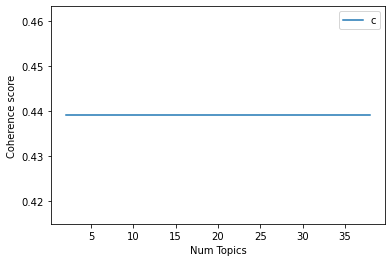

In [302]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs_clean, 
                                                        start=2, limit=40, step=6)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Sentiment Analysis to detect negative and positive reviews

Sentiment analysis is the process of identifying people's emotional states from text data. In this project, it will help to classify negative and positive reviews.



In [257]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
for sentence in df['comments'].values[1:3]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Hyas place was awesome!  She was very helpful and informative upon arrival.  She showed us around the place and gave us tips for things to do and places to eat around the neighborhood.  The place was quiet and big.  Plenty bang for your buck.  She even offered a ride to the train station upon check it to make sure we caught our flight on time.  Hya was amazing and I’d book with her again for sure!
compound: 0.9449, neg: 0.0, neu: 0.812, pos: 0.188, 
Sharon is super nice. the whole stay was great! We were group of six, having late night conversations. there was no problem, if we needed anything, we texted and got reply right away. The location is perfect, subway, cafe and little shop right across the street. We loved it. The place was super clean. 
compound: 0.9698, neg: 0.065, neu: 0.598, pos: 0.336, 


From VaderSentiment :

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
\
negative sentiment: compound score <= -0.05

In [258]:
pscores = [sid.polarity_scores(comment) for comment in df['comments']]

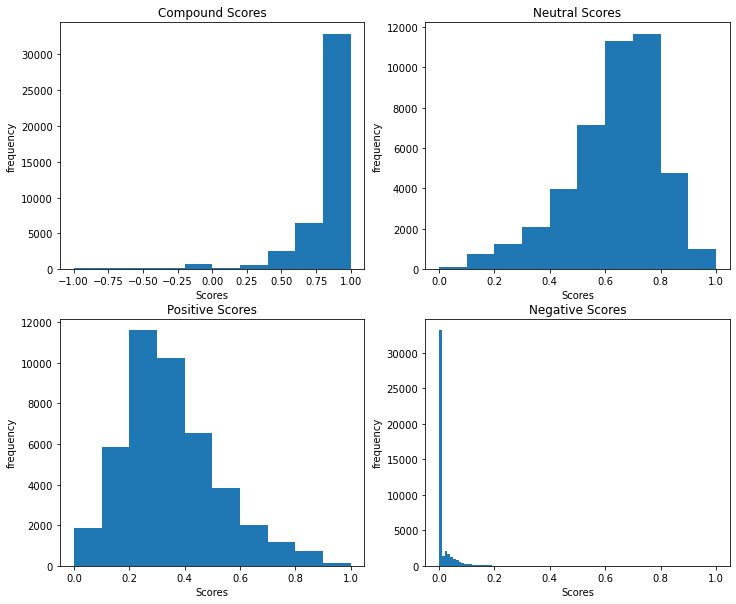

In [263]:
plt.subplots(figsize=(12,10))

plt.subplot(2, 2, 1)
pd.Series([score['compound'] for score in pscores]).plot(kind='hist')

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 2)
#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 3)

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.subplot(2, 2, 4)
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=100)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')


plt.savefig('sentiment.png',dpi =150)

#the negative scores were mostly close to zero. Most guest had pleasant experiences during their Airbnb stays.

In [271]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews['comments'] = df.comments
scored_reviews['comments_lmn'] = df.comments_lmn
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [272]:
scored_reviews.head()

,comments,comments_lmn,compound,negativity,neutrality,positivity
690518,Lakshmee was amazing ! Very nice for one night...,lakshmee be amaze very nice for one night she ...,0.9310,0.000,0.636,0.364
620226,Hyas place was awesome! She was very helpful ...,hyas place be awesome she be very helpful and ...,0.9449,0.000,0.812,0.188
560286,Sharon is super nice. the whole stay was great...,sharon be super nice the whole stay be great w...,0.9698,0.065,0.598,0.336
795187,"Nice apt, nice bathroom, nice mattress, but ve...",nice apt nice bathroom nice mattress but very ...,0.8466,0.067,0.592,0.341
846818,This was our first Airbnb rental. The place is...,this be our first airbnb rental the place be e...,0.9402,0.033,0.775,0.192


In [273]:
scored_reviews.query('negativity > positivity')

,comments,comments_lmn,compound,negativity,neutrality,positivity
389535,Place was as described. Everything was okay an...,place be a described everything be okay and ba...,-0.3708,0.096,0.869,0.035
847869,This stay was a disaster. The apartment was ve...,this stay be a disaster the apartment be very ...,-0.6757,0.128,0.819,0.053
729377,"No fridge, no proper A/C, $100/night deposit, ...",no fridge no proper a c night deposit and no v...,-0.4404,0.251,0.646,0.103
487828,"Clean, but no frills. Bathroom needs some cosm...",clean but no frill bathroom need some cosmetic...,-0.2382,0.168,0.721,0.111
798842,WRONG ROOM THEIR IS NO EMPIRE STATE BUILDING V...,wrong room their be no empire state building v...,-0.6900,0.255,0.670,0.075
...,...,...,...,...,...,...
537051,Bathroom was freezing. Shower walls had hair f...,bathroom be freeze shower wall have hair from ...,-0.8968,0.214,0.715,0.071
779920,Omg where do I start?! I stayed here for 2 wee...,omg where do i start i stay here for week and ...,-0.9717,0.137,0.808,0.055
504057,there was a big noise at early morning from ve...,there be a big noise at early morning from ven...,-0.0956,0.142,0.765,0.094
111459,"Unfortunately, we didn't get the room we have ...",unfortunately we didn t get the room we have b...,-0.0790,0.090,0.826,0.084


In [274]:
neg_reviews = scored_reviews.query('negativity > positivity')

In [317]:
neg_reviews.shape

(792, 6)

In [278]:
make_topics(neg_reviews.comments_lmn, None, TfidfVectorizer(stop_words=custom_stopwords,ngram_range=(1,3), max_df = 0.8), NMF(10, random_state=10));

C:\Users\12157\anaconda3\envs\metis\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 0:
 COMPLAINT, LITERALLY COMPLAINT, LONG COMPLAINT, COMPLAINT PARK, LITERALLY, LONG, PARK, FANTASTIC, CLOSE METRO COMPLAINT, METRO COMPLAINT 

Topic 1:
 APARTMENT, CLEAN, BATHROOM, BEDROOM, SMALL, FLOOR, PICTURE, WATER, HOUSE, EXPECT 

Topic 2:
 BAD, WASN BAD, BAD THING, WASN, BAD THING PARKING, THING PARKING, BED BAD, BAD EXPERIENCE, THING, BAD HOTEL 

Topic 3:
 BLOCK, SUBWAY, NEIGHBORHOOD, WALK, CLOSE, PARK, QUIET, SQUARE, CLOSE SUBWAY, BEST 

Topic 4:
 HOST, LEAVE, BOOK, SAY, WANT, GUEST, TELL, CANCEL, KEY, ASK 

Topic 5:
 PAY, PRICE, DECENT PAY, DECENT, FEE, HOTEL, PRICE PAY, PAY HOTEL FEE, PAY HOTEL, HOTEL FEE 

Topic 6:
 PROBLEM, PROBLEM PARK, RENT PROBLEM, PARK, RENT, REPEAT HESITATION, PROBLEM REPEAT, PROBLEM REPEAT HESITATION, HESITATION, REPEAT 

Topic 7:
 HIGHLY, DON HIGHLY, STEAL HIGHLY, STEAL, DON, DON WANT, WANT, PPL, DRYER, GREGORY 

Topic 8:
 HORRIBLE, BED, BED HORRIBLE, INSANITARY, HORRIBLE INSANITARY, UNCOMFORTABLE, WAKE BED, WOULDN WAKE BED, BED WOULDN, BED WOU